Implémentation Algorithme K-NN

In [1]:
import numpy as np
import random as rd
from math import sqrt
import itertools
from sklearn.datasets import load_iris
import collections
import operator
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

proches_voisins=[]

def distanc(X, Y):
    
    Y= np.array(Y)
    dist = np.linalg.norm(X-Y)
    return dist
    
# Création des namedtuple BT pour contenir les branches de l'arbre KD-Tree et NNRecord pour les couples point distance

BT = collections.namedtuple("BT", ["value", "left", "right"])
NNRecord = collections.namedtuple("NNRecord", ["point", "distance"])


def kdtree(points):
    """ Construction du k-d tree 
        Algorithme inspiré de  Wikipedia.
        > https://en.wikipedia.org/wiki/K-d_tree#Construction
    
    """
     # Dimension des points du dataset 
    k = len(points[0])
    def build(*, points, depth): 
        """ Retourne none s'il y a pas des points dans la liste  ou au cours de la création de l'arbre, il reste aucun point à insérer dans l'arbre
        """
        if len(points) == 0:
            return None
        
        # Tri des points selon x ou y  (le choix de x ou y se fait à l'aide de la profondeur et la dimension)
        points.sort(key=operator.itemgetter(depth % k))
        # Calcul de l'indice de la médiane  
        middle = len(points) // 2
        # Division des points à partir du middle en élements right et left et relancement de l'opération pour ces derniers 
        return BT(
            value = points[middle],
            left = build(
                points=points[:middle],
                depth=depth+1,
            ),
            right = build(
                points=points[middle+1:],
                depth=depth+1,
            ), )   
    return build(points=list(points), depth=0)


# Changement du nom de la fonction vu que le notebook essaye d'exécuter la fonction de recherche de la méthode naive
def cherche_k_voisins_KD_Tree(tree, point):
    """On cherche le point le plus proche dans l'arbre KD d'un point de test """
    # Dimension du point de test 
    k = len(point)
    best = None
    def search(*, tree, depth):
        # mettre best la variable la plus proche de x non locale à la fonction c'est à dire accessible hors la fonction
        nonlocal best
        if tree is None:
            return
        #Calcul de la distance entre le point et la racine de l'arbre ou les branches de l'arbre 
        distance = distanc(tree.value, point)
        #Si la distance est plus petite qu'à celle du best, on mis à jour best 
        if best is None or distance < best.distance and tree.value not in proches_voisins:
            best = NNRecord(point=tree.value, distance=distance)
        
        axis = depth % k
        # On calcule le différence entre le point et le point du tree 
        diff = point[axis] - tree.value[axis]
        # Si la différence est négative donc x est en gauche de l'axe du point sinon il est en droite
        if diff <= 0:
            close, away = tree.left, tree.right
        else:
            close, away = tree.right, tree.left
        # On continue la fouille dans le coté proche de x 
        search(tree=close, depth=depth+1)
        # On teste si le point x est très proche de l'axe soit x soit y donc il a forcèment des points proches 
        # dans le coté qui a été désigné loin 
        if diff**2 < best.distance:
            search(tree=away, depth=depth+1)
    search(tree=tree, depth=0)
    return best.point


def affiche( a,  k_voisins ):
  
# Création des deux tableaux (axe x et y) pour affichage des points de a (tableaux numpy)
   xx=[]
   yy=[]

# Création des deux tableaux (axe x et y) pour affichage des points de a (tableaux numpy)

   for i,j in a:
        xx.append(i)
        yy.append(j)
        
   ax = np.array(xx)
   ay= np.array(yy)
# Création des deux tableaux (axe x et y) pour affichage des points de k_voisins (tableaux numpy)
   x0=[]
   y=[]
   
   for i,j in tuple(k_voisins):
        x0.append(i)
        y.append(j)
   vx = np.array(x0)
   vy= np.array(y)
# Initialisation des propriétés de l'affichage
# Affichage 
   plt.title(f' Les {len(vx)} plus proches voisins du point x ')
   plt.xlabel('X')
   plt.ylabel('Y')
   plt.scatter(ax, ay,label="Points Moins Proches", color = 'gray')
   plt.scatter(vx, vy,label="Points Plus Proches",color = 'blue')
    #xx=np.array(x)
    #yy=np.array(x)
   plt.scatter(x[0], x[1],label="Point x",color = 'red')
   plt.legend()
   plt.show()

x=[0.3,0.6]

def sklearn_to_df(sklearn_dataset):
# Création dataFrame, colonnes caractéristiques (valeurs et étiquettes)
    df = pd.DataFrame(data=sklearn_dataset.data,
    columns=sklearn_dataset.feature_names)
# Ajout colonne variable à estimer
    df['target'] = sklearn_dataset.target
    return df

def classification(points,coluumns,dataset):
    # Création dataFrame, colonnes caractéristiques (valeurs et étiquettes)
    df = pd.DataFrame(data= points,columns=coluumns)
    # Ajout colonne variable à estimer
    df['target'] = dataset.target
     # Groupement des lignes par target et calcul des nombres de lignes par target
    a=pd.DataFrame({'count': df.groupby( [ "target"] ).size()}).reset_index()
    column = a["count"]
    max_index = column.idxmax()
     # La fonction retourne la classe à laquelle appartiennnent les points en arguments c'est la classe du max de nombres de lignes 
    return(df.loc[ max_index]['target'])

def test (datasett, Range_k,columns):   
    reference_points= []
    for y in datasett[columns].values: 
        reference_points.append(tuple (y))
    results_précisionn,results_prédiction, results_temps_execution=dict(),[],dict()
    xy_train, xy_test, lab_train, lab_test = train_test_split(datasett[columns].values, 
    datasett['target'].values, 
    test_size=0.2,random_state=0,
    stratify=datasett['target'])#print(xy_test)          
    for k in Range_k:
        proches_voisins=[]
        start = time.time()
        tree = kdtree(reference_points)
        cherche_k_voisins_KD_Tree(tree=tree, point=x)
        i=0  
        for i in range(k):
            proches_voisins.append(cherche_k_voisins_KD_Tree(tree=tree, point=x))
        classification(proches_voisins,columns,datasett)
        end = time.time()
        results_temps_execution[k]=end-start 
    # Calcul de justesse de l'algorithme de classification sur les points de test
    Tree = kdtree(reference_points)
    for k in Range_k:
        proches_voisins=[]
        j=0        
        for j in range(len(xy_test)):
            cherche_k_voisins_KD_Tree(tree=Tree, point=xy_test[j])
            i=0  
            for i in range(k):
                proches_voisins.append(cherche_k_voisins_KD_Tree(tree=Tree, point=xy_test[j]))
            results_prédiction.append(classification(proches_voisins,columns,datasett))
        results_précisionn[k] = metrics.accuracy_score(lab_test,results_prédiction)
        results_prédiction=[]
    return [results_précisionn,results_temps_execution]


#print(df)

trois jeux de données
20 valeurs de k
Justesse et temps d'exécution 
Programme sickit-learn 

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import pandas as pd
import array
import time


def sklearn_to_df(dataset):
# Création dataFrame, colonnes caractéristiques (valeurs et étiquettes)
    df = pd.DataFrame(data=dataset.data,columns=dataset.feature_names)
# Ajout colonne variable à estimer
    df['target'] =dataset.target
    return df
def test1(datasett, Range_k, columns):
    xy_train, xy_test, lab_train, lab_test = train_test_split(datasett[columns].values,
                                     datasett['target'], test_size=0.2, random_state=0,stratify=datasett['target']) 
# Construction du modèle d'entrainement
    results_précision=dict()
    results_temps_execution=dict()
    for k in Range_k:
        start = time.time()
        model=KNeighborsClassifier(n_neighbors=k)
        #entrainement
        model.fit(xy_train,lab_train)
        #Prédiction
        model.predict([x])
        end = time.time()
        results_temps_execution[k]=end-start
        #Calcul de la justesse
        results_précision[k]=model.score(xy_test, lab_test)
    return [results_précision,results_temps_execution]  



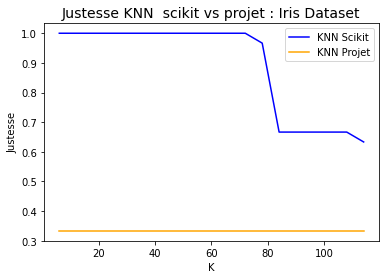

In [3]:
iris = load_iris()
# Chargement du jeu de données et création d'une structure DataFrame Pandas
I = sklearn_to_df(iris) 
Range_k = range(6,120,6)
project=test(I ,Range_k,['petal length (cm)','petal width (cm)'])
sickit=test1(I ,Range_k,['petal length (cm)','petal width (cm)'])
plt.plot(sickit[0].keys(),sickit[0].values(),color='blue',label="KNN Scikit")
plt.plot(project[0].keys(),project[0].values(),color='orange',label="KNN Projet")
plt.title(f"Justesse KNN  scikit vs projet : Iris Dataset" , fontsize=14)
plt.xlabel("K")
plt.ylabel("Justesse")
plt.legend()


[{6: 0.3333333333333333, 12: 0.3333333333333333, 18: 0.3333333333333333, 24: 0.3333333333333333, 30: 0.3333333333333333, 36: 0.3333333333333333, 42: 0.3333333333333333, 48: 0.3333333333333333, 54: 0.3333333333333333, 60: 0.3333333333333333, 66: 0.3333333333333333, 72: 0.3333333333333333, 78: 0.3333333333333333, 84: 0.3333333333333333, 90: 0.3333333333333333, 96: 0.3333333333333333, 102: 0.3333333333333333, 108: 0.3333333333333333, 114: 0.3333333333333333}, {6: 0.00945138931274414, 12: 0.008317947387695312, 18: 0.06297659873962402, 24: 0.02340531349182129, 30: 0.0157318115234375, 36: 0.0, 42: 0.021184921264648438, 48: 0.022992372512817383, 54: 0.0010249614715576172, 60: 0.03300046920776367, 66: 0.01933455467224121, 72: 0.02129530906677246, 78: 0.021282434463500977, 84: 0.02137589454650879, 90: 0.0291903018951416, 96: 0.02089524269104004, 102: 0.03021407127380371, 108: 0.03441953659057617, 114: 0.027379989624023438}]


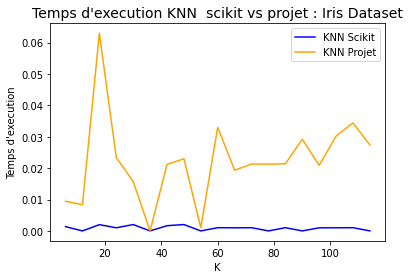

In [4]:
iris = load_iris()
# Chargement du jeu de données et création d'une structure DataFrame Pandas
I = sklearn_to_df(iris) 
Range_k = range(6,120,6)
project=test(I ,Range_k,['petal length (cm)','petal width (cm)'])
print(project)
sickit=test1(I ,Range_k,['petal length (cm)','petal width (cm)'])
plt.plot(sickit[1].keys(),sickit[1].values(),color='blue',label="KNN Scikit")
plt.plot(project[1].keys(),project[1].values(),color='orange',label="KNN Projet")
plt.title(f"Temps d'execution KNN  scikit vs projet : Iris Dataset" , fontsize=14)
plt.xlabel("K")
plt.ylabel("Temps d'execution")
plt.legend()


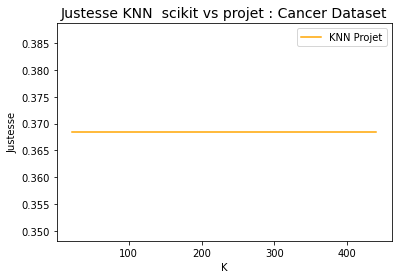

In [5]:
cancer = load_breast_cancer()
L = sklearn_to_df(cancer)
Range_k = range(22,455,22) 
project=test(L ,Range_k,['mean perimeter','mean symmetry'])
sickit=test1(L ,Range_k,['mean perimeter','mean symmetry'])
#plt.plot(sickit[0].keys(),sickit[0].values(),color='blue',label="KNN Scikit")
plt.plot(project[0].keys(),project[0].values(),color='orange',label="KNN Projet")
plt.title(f"Justesse KNN  scikit vs projet : Cancer Dataset" , fontsize=14)
plt.xlabel("K")
plt.ylabel("Justesse")
plt.legend()


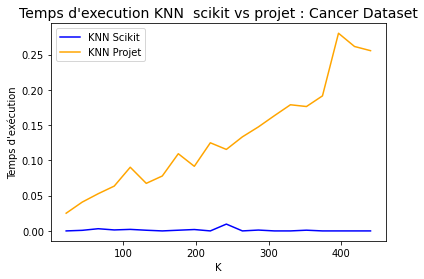

In [6]:
cancer = load_breast_cancer()
L = sklearn_to_df(cancer)
Range_k = range(22,455,22) 
project=test(L,Range_k,['mean perimeter','mean symmetry'])
sickit=test1(L,Range_k,['mean perimeter','mean symmetry'])
plt.plot(sickit[1].keys(),sickit[1].values(),color='blue',label="KNN Scikit")
plt.plot(project[1].keys(),project[1].values(),color='orange',label="KNN Projet")
plt.title(f"Temps d'execution KNN  scikit vs projet : Cancer Dataset" , fontsize=14)
plt.xlabel("K")
plt.ylabel("Temps d'exécution")
plt.legend()
